In [2]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from transformers import BertModel
from datasets import load_dataset

In [3]:
import numpy as np
from scipy.io import loadmat

harry_potter = loadmat('data/brain_data/subject_1.mat')


words = []
for i in range(5176):
    word = harry_potter['words'][0][i][0][0][0][0]
    words.append(word)

word_times = []
for i in range(5176):
    word_time = harry_potter['words'][0][i][1][0][0]
    word_times.append(word_time)

tr_times = []
for i in range(1351):
    tr_time = harry_potter['time'][i,0]
    tr_times.append(tr_time)

dont_include_indices = [i for i in range(15)] + [i for i in range(335,355)] + [i for i in range(687,707)] + [i for i in range(966,986)] + [i for i in range(1346,1351)]

X_fmri = harry_potter['data']

useful_X_fmri = np.delete(X_fmri, dont_include_indices,axis=0)

tr_times_arr = np.asarray(tr_times)

useful_tr_times = np.delete(tr_times_arr, dont_include_indices)

sentences = [[]]*1271
for idx, useful_tr_time in enumerate(useful_tr_times):
    sentence= []
    for word, word_time in zip(words,word_times):
        if useful_tr_time - 10 <= word_time <= useful_tr_time:
            sentence.append(word)
    sentences[idx] = sentence   

In [4]:
actual_sentences = ['']*1271
for idx, sentence in enumerate(sentences):
    for word in sentence:
        actual_sentences[idx] = actual_sentences[idx] + word + ' '

In [5]:
useful_X_fmri.shape

(1271, 37913)

In [9]:
class BrainBiasedBERT(nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.linear = nn.Linear(768,37913)
    def forward(self, x):
        embeddings = self.tokenizer(x, return_tensors='pt', padding=True)
        representations = self.bert(**embeddings).last_hidden_state
        cls_representation = representations[:,0,:]
        pred_fmri = self.linear(cls_representation)
        return pred_fmri

In [49]:
model = BrainBiasedBERT()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
pred_fmri = model(actual_sentences[:5])
pred_fmri.shape

torch.Size([5, 37913])

In [15]:
fmri = torch.as_tensor(useful_X_fmri)
truth_fmri = fmri[:5,:]
truth_fmri.shape

torch.Size([5, 37913])

In [50]:
loss_function = nn.MSELoss()

In [16]:
loss_function(pred_fmri, truth_fmri)

tensor(313270.9688, grad_fn=<MseLossBackward0>)

In [51]:
from torch.utils.data import DataLoader

dataset = []
for i in range(1271):
    dataset.append((actual_sentences[i], fmri[i,:]))
    
#TRAIN TEST SPLIT HAS OVERLAP IN WORDS AND IN BRAIN STATE
n_rows = len(dataset)
train_dataset = dataset[:int(.8*n_rows)]
val_dataset = dataset[int(.8*n_rows):]

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

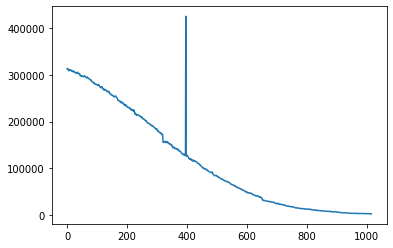

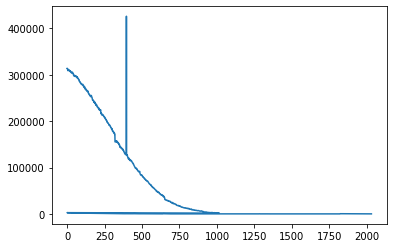

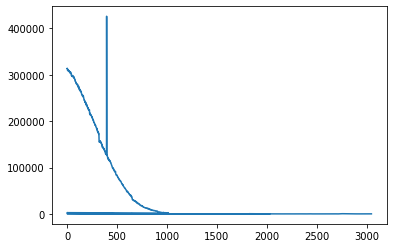

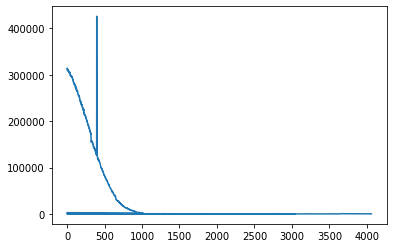

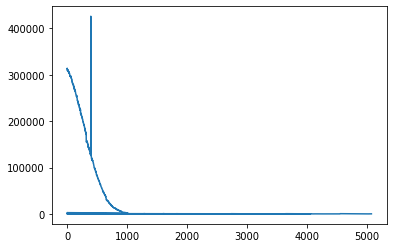

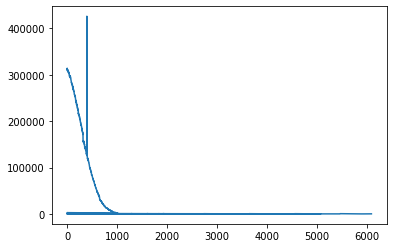

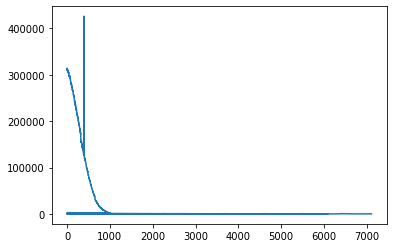

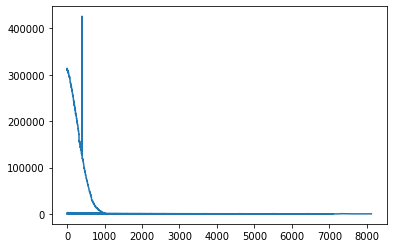

KeyboardInterrupt: 

In [52]:
full_num_epochs = 15
loss_over_time = []
time = []
import matplotlib.pyplot as plt

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
for epoch in range(full_num_epochs):
    epoch += 1
    for batch_idx, (data, targets) in enumerate(train_dataloader):
        #print(data[0])
        #print(targets)
        preds = model(data[0])
        loss = loss_function(preds, targets.float())
        loss_over_time.append(loss.item())
        time.append(batch_idx*epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    plt.plot(time, loss_over_time)
    plt.show()

In [57]:
#model.eval()
#with torch.no_grad():
#    test_losses = []
#    for x, y in test_dataloader:
#        preds = model(x[0])
#        test_loss = loss_function(preds,y.float())
#        test_losses.append(test_loss)
        
#print(torch.mean(torch.as_tensor(test_losses))) 
#model.train()

In [56]:
torch.save(model.state_dict(), 'state_dict')

# Loading evaluation suite

In [58]:
mnli = load_dataset('multi_nli')

Using custom data configuration default


Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Dataset multi_nli downloaded and prepared to /home/ubuntu/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [76]:
mnli['validation_matched']['gold_label']

KeyError: "Column gold_label not in the dataset. Current columns in the dataset: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label']"

In [ ]:

# telephone - face2face/letter
header = ['index'] + list(train.columns)

def write_split(s, tag, genre):
    cnt = 0
    with open("{}.tsv".format(tag), 'w', encoding="UTF-8") as fout:
        writer = csv.writer(fout, delimiter='\t')
        writer.writerow(header)
        for i in s.itertuples():
            if i[3] == genre:
                cnt += 1
                writer.writerow(list(i))
    print(genre, cnt)

write_split(train, "train-telephone", "telephone")
write_split(dev, "dev-telephone", "telephone")
write_split(dev, "dev-letters", "letters")
write_split(dev, "dev-facetoface", "facetoface")
© 2022 GitHub, Inc.
Terms
Privacy
Security
Status
Docs
Contact 